<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FINAL PROJECT**
# **American Option Portfolio Value-at-Risk (VaR)**

### **INTRODUCTION**
  ▶ What is an **option**?
  
  An option is a financial contract that gives someone the right (but not the obligation) to buy or sell something in the future, like a stock.

  - A call option = right to buy

  - A put option = right to sell


▶ What is an **American Option**?

There are two main types:

  - European option: can only be exercised at the end

  - American option: can be exercised at any time before or on the expiration date


▶  Why are American Options **harder to value**?

Because we do not know when the holder will choose to exercise it. We need a smart way to decide if holding the option is better than using it right now.


▶  We introduce: **Longstaff-Schwartz Algorithm**

This algorithm helps us estimate the best time to exercise an American option.
It works like this:
  
  1. Simulate multiple price paths for the underlying stock.

  2. At each time step, calculate:

    - The immediate payoff from exercising

    - The expected value of holding it longer (using regression)

    - Exercise the option if it is better than holding it.

  3. Repeat for many paths and average results to estimate the option’s value.

▶ **Portfolio** VaR calculation

We will follow this steps in this project:

  1. Simulating portfolio values under many market conditions.

  2. Calculating the distribution of possible profits and losses (P&L).

  3. Taking the 5th percentile (for 95% VaR) — this is the estimated worst loss.


**DATA**:

We will use SPY ticker, because:

- It’s a real security

- You can get actual option prices for validation

- American options exist and trade on SPY (but not on ^GSPC)

[*********************100%***********************]  1 of 1 completed


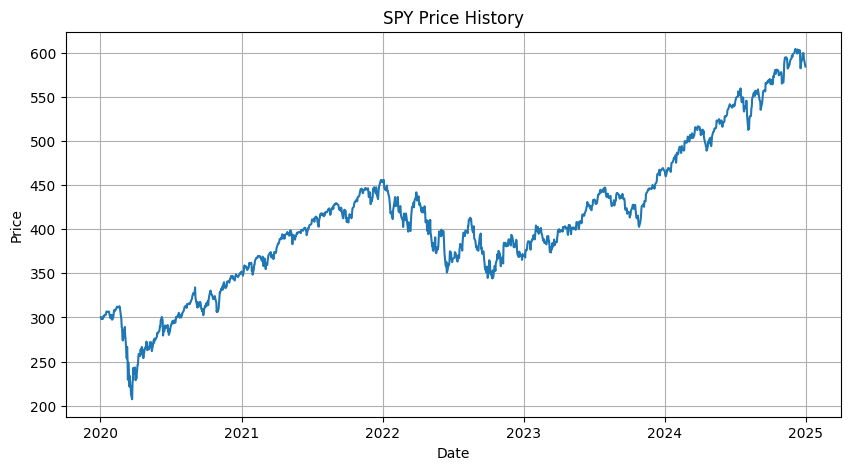

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ticker = 'SPY'
start_date = '2020-01-01'
end_date = '2025-01-01'

spy_data = yf.download(ticker, start=start_date, end=end_date)
spy_data = spy_data[['Close']].rename(columns={'Close': 'Price'})

plt.figure(figsize=(10, 5))
plt.plot(spy_data.index, spy_data['Price'])
plt.title('SPY Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


Annualized Mean Return (mu): 0.1335
Annualized Volatility (sigma): 0.2108


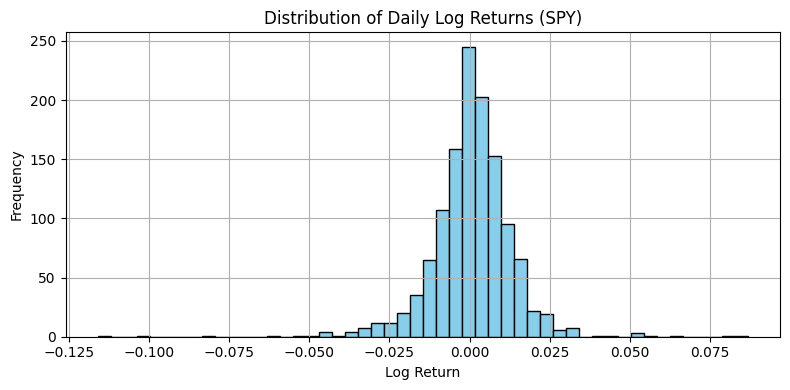

In [4]:
spy_data['LogReturn'] = np.log(spy_data['Price'] / spy_data['Price'].shift(1))
spy_data.dropna(inplace=True)

mu_daily = spy_data['LogReturn'].mean()
sigma_daily = spy_data['LogReturn'].std()

mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

print(f"Annualized Mean Return (mu): {mu_annual:.4f}")
print(f"Annualized Volatility (sigma): {sigma_annual:.4f}")

plt.figure(figsize=(8, 4))
plt.hist(spy_data['LogReturn'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Daily Log Returns (SPY)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#**PRELIMINAR ANALYSIS**
On the one hand, a mean return of aprox 13.35% is a reasonable average annual return as the long term average for the S&P 500 is usually around 7%–10% (after inflation). Also some recent 5-year windows (like post-COVID recovery) have been higher — so 13% is very plausible.

On the other hand, volatility is of aprox 21.08%. This is also a realistic result, as SPY's volatility usually ranges between 15%–25% annually. Events like COVID crash (2020), inflation spikes (2022) and tech growth rebound (2023–2024) all contribute to volatility in your 5-year window.

#**IMPLEMENTATION**
**Monte Carlo Simulation (using GBM)**

We simulate future asset prices by generating multiple random paths based on the Geometric Brownian Motion (GBM) model:

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \cdot \sqrt{\Delta t} \cdot Z_t\right]
$$

Where:
- $ S_t $: asset price at time $ t $
- $ \mu $: expected return
- $ \sigma $: volatility
- $ \Delta t $: time step (1/252 for daily simulation)
- $ Z_t \sim \mathcal{N}(0, 1) $: standard normal random variable

This method generates multiple possible price paths to estimate the future distribution of asset prices.


In [6]:
S0 = spy_data['Price'].iloc[-1]
print(S0)
mu = mu_annual
sigma = sigma_annual

T = 1
N = 252
dt = T / N
n_paths = 1000

np.random.seed(42)
Z = np.random.standard_normal((N, n_paths))

price_paths = np.zeros((N + 1, n_paths))
price_paths[0] = S0

# Apply GBM formula to simulate paths
for t in range(1, N + 1):
    price_paths[t] = price_paths[t - 1] * np.exp(
        (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t - 1]
    )

simulated_prices = pd.DataFrame(price_paths)
simulated_prices.head()

Ticker
SPY    584.322266
Name: 2024-12-31 00:00:00, dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,...,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266,584.322266
1,588.449546,583.507720,589.630675,596.525667,582.765063,582.765190,596.970959,590.569180,580.946514,588.807965,...,586.200393,568.940929,582.664265,579.309125,576.855018,582.401805,598.705689,589.577068,580.162303,589.042799
2,599.753187,590.978512,590.358361,591.683184,588.454152,586.077386,604.377757,595.835280,589.361525,584.895224,...,592.726918,574.923033,592.199262,585.042800,579.809814,590.999553,598.759066,582.969088,579.162738,583.501349
3,594.661409,590.105667,584.435580,589.528174,574.092333,587.999505,604.654265,589.664322,594.807009,592.485571,...,605.052520,579.795029,593.027828,583.653762,572.778207,591.869231,601.077598,573.686472,581.995831,582.556440
4,580.038746,583.658324,581.490494,604.762218,578.607024,577.916973,608.838807,577.925058,603.688432,589.049747,...,591.890506,576.431733,577.925604,589.765561,557.527832,592.354380,584.974841,571.503363,595.101104,585.611989


#**SETTINGS**
- Option type: put
- Strike price: 600

In [7]:
import numpy as np

def price_american_put_longstaff(S, K, r=0.05, T=1, N=252):
    """
    Price an American put option using the Longstaff-Schwartz algorithm.

    Parameters:
    - S: simulated price paths (2D array: [time, paths])
    - K: strike price
    - r: risk-free rate
    - T: maturity (in years)
    - N: number of time steps

    Returns:
    - Estimated option price
    """
    dt = T / N
    discount = np.exp(-r * dt)
    n_paths = S.shape[1]

    # Start with payoffs at maturity
    payoffs = np.maximum(K - S[-1], 0)

    # Backward induction
    for t in range(N - 1, 0, -1):
        itm = np.where(K - S[t] > 0)[0]  # in-the-money paths
        if len(itm) == 0:
            continue

        X = S[t, itm]
        Y = payoffs[itm] * discount

        # Regress continuation value on price
        A = np.vstack([np.ones(len(X)), X, X**2]).T
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
        continuation = coeffs[0] + coeffs[1]*X + coeffs[2]*X**2

        exercise = K - X
        exercise_now = exercise > continuation
        update_indices = itm[exercise_now]
        payoffs[update_indices] = exercise[exercise_now]

        # Discount payoffs for next step
        payoffs *= discount

    return np.mean(payoffs)

# Example usage
K = 600  # strike price
american_put_price = price_american_put_longstaff(simulated_prices.values, K)
print(f"American Put Price (K={K}): ${american_put_price:.4f}")


American Put Price (K=600): $36.1083


#**References**
[1] Glasserman, Monte Carlo Methods in Financial Engineering, Ch. 8

[2] Palczewski, Computational Finance Lecture Notes, Ch. 8

[3] McNeil, Frey, Embrechts, Quantitative Risk Management (for risk metrics background)